# FlowSurfer: Introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.tri import Triangulation 
from mne import spatial_tris_connectivity
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import Delaunay
from scripts.diagnostics import *
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Background
For ease of calculating statistical significance, modern neuroimaging softwares (e.g. FSL, SPM) rely on simplifying assumptions about the temporal and spatial autocorrelation of fMRI data.$^1$ Recent work has shown these assumptions can yield high degrees of false positives$^{2,3}$, prompting calls for new methods.$^{3,4}$ One promising avenue is Bayesian inference whereby spatiotemporal priors have been shown to regularize parameter estimates and improve inference.$^{5–7}$ To date, most Bayesian fMRI models assume volumetric data (i.e. 3d voxels). In contrast, there is a growing consensus in the neuroimaging community èthat the sheet-like cortex is better represented on a 2d surface.$^8$ Indeed studies comparing volume- vs. surface-based analysis (using triangular meshes from Freesurfer9,10) have found improved intra-subject anatomical alignment and detection of BOLD signal.$^{11–13}$ There is thus an unmet need for new inference methods for surface-based fMRI data.


## Representative Example

### Triangular Mesh
The Freesurfer cortical surface is represented by a triangular mesh. 

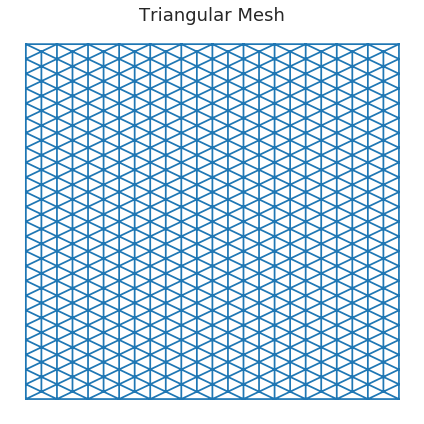

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Mesh parameters.
nrow = 25
ncol = 25

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define positions of vertices.
rr = []
for i in np.arange(nrow):
    if i % 2: pos = np.vstack([np.ones(ncol-1)*i, np.arange(ncol-1)+0.5, ])
    else: pos = np.vstack([np.ones(ncol)*i, np.arange(ncol), ])
    rr.append(pos)
rr = np.concatenate(rr, axis=-1).T
V, _ = rr.shape

## Normalize xy-coordinators (0-1).
rr[:,0] /= nrow - 1.
rr[:,1] /= ncol - 1.

## Define triangles.
tris = Delaunay(rr).simplices
tris = np.sort(tris, axis=1)
tris = tris[np.lexsort(tris.T)]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fig, ax = plt.subplots(1,1,figsize=(6,6))
mtri = Triangulation(rr[:,0], rr[:,1], tris)

## Visualize mesh.
ax.triplot(mtri)
ax.set(xticks=[], yticks=[], title='Triangular Mesh')

sns.despine(left=True, bottom=True)
plt.tight_layout()

### Simulated Activation
fMRI voxels are sampled onto the vertices of the mesh. Activation is visualized by linear interpolation of the vertices of a triangle.

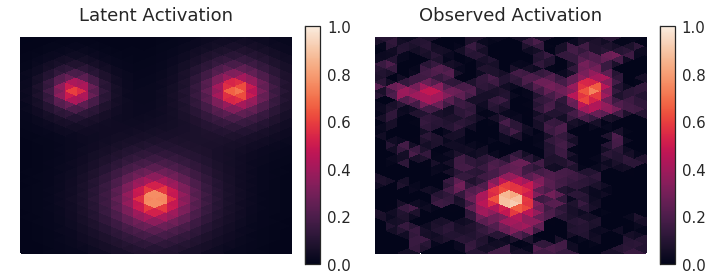

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Metadata
T = 50

## Activation parameters.
loc = [(0.20,0.75),(0.5,0.25),(0.80,0.75)]
ext = [0.05, 0.10, 0.075]

## Noise parameters.
SNR = 1

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Generate latent activations.
Z = np.zeros(V)
for mu, l in zip(loc, ext):
    Z += np.exp( -np.linalg.norm(rr - np.array(mu), axis=-1) / l )
Z /= Z.max()
Z *= SNR
    
## Add noise.
Y = np.random.normal(loc=0, scale=1, size=(T,Z.size))
Y += Z

## Save example data.
np.savez_compressed('data/example.npz', rr=rr, tris=tris, Z=Z, Y=Y)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))

## Visualize latent activation.
for ax, arr, title in zip(axes, [Z, Y.mean(axis=0)], ['Latent','Observed']):

    ## Set up plot.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0)
    
    ## Plot.
    cbar = ax.tripcolor(mtri, arr, vmin=0, vmax=1)
    plt.colorbar(cbar, cax=cax)
    ax.set(xticks=[], yticks=[], title='%s Activation' %title)
    
sns.despine(bottom=True, left=True, right=False)
plt.tight_layout()

### Mass univariate analysis

We observe some data, $Y$ of size $V$. We model $Y$ as normally distributed:

$$ Y \sim \mathcal{N}(\vec{w}, \sigma I) $$

where $\vec{w}$ is a vector of regression weights of size $V$ with independent noise scaled by $\sigma^2$.

$$ \vec{w} \sim \mathcal{MVN}( \vec{0}, I_v ) $$


#### Stan Model

In [4]:
model_code = '''
data {

    // Metadata
    int T;                  // Number of times
    int V;                  // Number of vertices
    
    // Data
    matrix[T,V] Y;            // Observations

}
parameters {

    vector[V] w;            // Regression weights
    real<lower=0> sigma;    // Residual variance

}
model {

    // Priors
    w ~ normal(0, 1);
    sigma ~ gamma(1, 0.5);

    // Likelihood
    for (i in 1:V){
        Y[:,i] ~ normal(w[i], sigma);
    }

}
'''

#### Estimate model

In [5]:
import pystan

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Sampling parameters.
samples = 1000
warmup = 750
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Model Fitting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
data = dict(T=T, V=V, Y=Y)

## Fit model with Stan.
StanFit = pystan.stan(model_code=model_code, data=data, iter=samples, warmup=warmup, 
                      thin=thin, chains=chains, n_jobs=n_jobs, seed=47404)
for f in [check_div, check_treedepth, check_energy, check_n_eff, check_rhat]: f(StanFit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fe205756aa62518676b74bf2f983e2ca NOW.
/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


0.0 of 1000 iterations ended with a divergence (0.0%)
0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior
n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters


#### Plot results

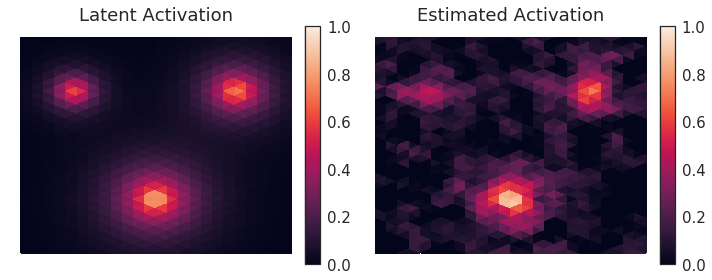

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))

## Extract data.
fit = StanFit.extract()

## Visualize latent activation.
for ax, arr, title in zip(axes, [Z, np.median(fit['w'], axis=0)], ['Latent','Estimated']):

    ## Set up plot.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0)
    
    ## Plot.
    cbar = ax.tripcolor(mtri, arr, vmin=0, vmax=1)
    plt.colorbar(cbar, cax=cax)
    ax.set(xticks=[], yticks=[], title='%s Activation' %title)
    
sns.despine(bottom=True, left=True, right=False)
plt.tight_layout()

## References
1.	Hayasaka, S. & Nichols, T. E. Validating cluster size inference: random field and permutation methods. Neuroimage 20, 2343–2356 (2003).
2.	Eklund, A., Andersson, M., Josephson, C., Johannesson, M. & Knutsson, H. Does parametric fMRI analysis with SPM yield valid results?—An empirical study of 1484 rest datasets. Neuroimage 61, 565–578 (2012).
3.	Eklund, A., Nichols, T. E. & Knutsson, H. Cluster failure: Why fMRI inferences for spatial extent have inflated false-positive rates. Proc. Natl. Acad. Sci. U. S. A. 113, 7900–7905 (2016).
4.	Winkler, A. M., Ridgway, G. R., Webster, M. A., Smith, S. M. & Nichols, T. E. Permutation inference for the general linear model. Neuroimage 92, 381–397 (2014).
5.	Penny, W. D., Trujillo-Barreto, N. J. & Friston, K. J. Bayesian fMRI time series analysis with spatial priors. Neuroimage 24, 350–362 (2005).
6.	Woolrich, M. W. Bayesian inference in FMRI. Neuroimage 62, 801–810 (2012).
7.	Sidén, P., Eklund, A., Bolin, D. & Villani, M. Fast Bayesian whole-brain fMRI analysis with spatial 3D priors. Neuroimage 146, 211–225 (2017).
8.	Glasser, M. F. et al. The Human Connectome Project’s neuroimaging approach. Nat. Neurosci. 19, 1175–1187 (2016).
9.	Fischl, B., Sereno, M. I., Tootell, R. B. & Dale, A. M. High-resolution intersubject averaging and a coordinate system for the cortical surface. Hum. Brain Mapp. 8, 272–284 (1999).
10.	Fischl, B. FreeSurfer. Neuroimage 62, 774–781 (2012).
11.	Fischl, B. et al. Cortical folding patterns and predicting cytoarchitecture. Cereb. Cortex 18, 1973–1980 (2008).
12.	Tucholka, A., Fritsch, V., Poline, J.-B. & Thirion, B. An empirical comparison of surface-based and volume-based group studies in neuroimaging. Neuroimage 63, 1443–1453 (2012).
13.	Turner, R. & Geyer, S. Comparing like with like: the power of knowing where you are. Brain Connect. 4, 547–557 (2014).
14.	Gössl, C., Auer, D. P. & Fahrmeir, L. Bayesian spatiotemporal inference in functional magnetic resonance imaging. Biometrics 57, 554–562 (2001).
15.	Mejia, A., Yue, Y. R., Bolin, D., Lindren, F. & Lindquist, M. A. A Bayesian General Linear Modeling Approach to Cortical Surface fMRI Data Analysis. arXiv [stat.AP] (2017).
16.	Bolin, D. & Lindgren, F. Excursion and contour uncertainty regions for latent Gaussian models. J. R. Stat. Soc. Series B Stat. Methodol. 77, 85–106 (2015).
17.	Verstynen, T. D. The organization and dynamics of corticostriatal pathways link the medial orbitofrontal cortex to future behavioral responses. J. Neurophysiol. 112, 2457–2469 (2014).
